The goal of this notebook is to make a clean working funciton or class object to perform the width subtraction procedure
or the Gaussian deconvolution procedure for estimating $C_\alpha$ distances from processed DEER data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon as js
import random
from scipy.spatial import distance
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import os
import scipy
from scipy import signal
import pandas as pd
from scipy.signal import savgol_filter
import chilife as xl
import MDAnalysis as mda
from MDAnalysis.analysis import distances

In [2]:
def gaus(peak, fwhm, min=10, max=100, interval=0.1):
    
    #creates a gaussian with specified values

    r = np.arange(min, max, interval)
    s = fwhm
    _r = peak #nm
    
    gaussian = np.array(0.01*(1/(np.sqrt(2*np.pi)*s))*np.exp((-(r-_r)**2)/(2*s**2)))

    #eliminates small values - 0 probability for BRER case
    gaussian[gaussian < 2e-06] = 0
    
    data = np.array([r, gaussian])
    return data

def gaus_model(x, amp, peak, fwhm): 
    return amp * np.exp(-(x - peak) ** 2 / (2 * fwhm ** 2))

def gaus2_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2): 
    return amp1 * np.exp(-(x - peak1) ** 2 / (2 * fwhm1 ** 2)) +\
            amp2 * np.exp(-(x - peak2) ** 2 / (2 * fwhm2 ** 2)) 

def gaus3_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2, amp3, peak3, fwhm3): 
    return amp1 * np.exp(-(x - peak1) ** 2 / (2 * fwhm1 ** 2)) +\
            amp2 * np.exp(-(x - peak2) ** 2 / (2 * fwhm2 ** 2)) +\
              amp3 * np.exp(-(x - peak3) ** 2 / (2 * fwhm3 ** 2))

def gaus4_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2, amp3, peak3, fwhm3, amp4, peak4, fwhm4): 
    return amp1 * np.exp(-(x - peak1) ** 2 / (2 * fwhm1 ** 2)) +\
            amp2 * np.exp(-(x - peak2) ** 2 / (2 * fwhm2 ** 2)) +\
              amp3 * np.exp(-(x - peak3) ** 2 / (2 * fwhm3 ** 2)) +\
                amp4 * np.exp(-(x - peak4) ** 2 / (2 * fwhm4 ** 2))

def gaus5_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2, amp3, peak3, fwhm3, amp4, peak4, fwhm4, amp5, peak5, fwhm5): 
    return amp1 * np.exp(-(x - peak1) ** 2 / (2 * fwhm1 ** 2)) +\
            amp2 * np.exp(-(x - peak2) ** 2 / (2 * fwhm2 ** 2)) +\
              amp3 * np.exp(-(x - peak3) ** 2 / (2 * fwhm3 ** 2)) +\
                amp4 * np.exp(-(x - peak4) ** 2 / (2 * fwhm4 ** 2)) +\
                  amp5 * np.exp(-(x - peak5) ** 2 / (2 * fwhm5 ** 2))

def loren_model(x, amp, peak, fwhm):
    return amp * (1/3.141592)*(1/2*fwhm)/(((x-peak)**2) + (1/2*fwhm)**2)

def loren2_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2):
    return amp1 * (1/3.141592)*(1/2*fwhm1)/(((x-peak1)**2) + (1/2*fwhm1)**2) +\
            amp2 * (1/3.141592)*(1/2*fwhm2)/(((x-peak2)**2) + (1/2*fwhm2)**2)

def loren3_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2, amp3, peak3, fwhm3):
    return amp1 * (1/3.141592)*(1/2*fwhm1)/(((x-peak1)**2) + (1/2*fwhm1)**2) +\
            amp2 * (1/3.141592)*(1/2*fwhm2)/(((x-peak2)**2) + (1/2*fwhm2)**2) +\
              amp3 * (1/3.141592)*(1/2*fwhm3)/(((x-peak3)**2) + (1/2*fwhm3)**2)

def loren4_model(x, amp1, peak1, fwhm1, amp2, peak2, fwhm2, amp3, peak3, fwhm3, amp4, peak4, fwhm4):
    return amp1 * (1/3.141592)*(1/2*fwhm1)/(((x-peak1)**2) + (1/2*fwhm1)**2) +\
            amp2 * (1/3.141592)*(1/2*fwhm2)/(((x-peak2)**2) + (1/2*fwhm2)**2) +\
              amp3 * (1/3.141592)*(1/2*fwhm3)/(((x-peak3)**2) + (1/2*fwhm3)**2) +\
                amp4 * (1/3.141592)*(1/2*fwhm4)/(((x-peak4)**2) + (1/2*fwhm4)**2)

In [3]:
path_to_deer = r'C:\Users\ju21289\OneDrive - mcw.edu\Lerch Lab\LerchLab - EPR Data\PR_DEER_PAPER\B2D6M_148_266-IAP_DDM_noFT\0KBAR'

#how to load long distances data
# POPC_1600uM_dist_LD = pd.read_csv('POPC_1600uM/LD_Results/b2d6m_148266IAP_POPC_1600uM_iso_10x_071723JG_DIST.txt', encoding='unicode_escape', sep='\t')
# POPC_1600uM_err_LD  = pd.read_csv('POPC_1600uM/LD_Results/b2d6m_148266IAP_POPC_1600uM_iso_10x_071723JG_DIST_ERROR_@00E0DC5E8A.txt', encoding='unicode_escape', sep='\t')

#how to load DEERAnalysis Data -- use with smoothed fxn
# POPG_1600_da_dist = pd.read_csv('POPG_1600uM/b2d6m_148266iap_POPG_1600uM_iso_10x_071723jg_consensus_DEER_distribution.csv', header=0, names=['R','Probability', 'lower', 'upper'])

pdeer_0_148266 = pd.read_csv(path_to_deer+r'\14 SCANS_consensus_DEER_distribution.csv', header=0, names=['R','Probability', 'lower', 'upper'])

def smooth(data, window=15, poly=3):
    columns = ['R', 'Probability', 'lower', 'upper']
    data.columns = columns
    
    smoothed = data.apply(savgol_filter,  window_length=window, polyorder=poly)
    return smoothed

pdeer_0_148266 = smooth(pdeer_0_148266)

In [11]:
param_0kbar_3g, cov_0kbar_3g = curve_fit(gaus3_model,pdeer_0_148266['R'], pdeer_0_148266['Probability'], 
                                         p0=np.tile([0.001, 40, 4],3), bounds=(np.tile([0,0,0],3),np.tile([np.inf,np.inf,7],3)))

p0_4g = [0.01, 40, 4, 0.01, 50, 3, 0.01, 30, 3, 0.01, 55, 3]
param_0kbar_4g, cov_0kbar_4g = curve_fit(gaus4_model,pdeer_0_148266['R'], pdeer_0_148266['Probability'], 
                                         p0=np.tile([0.001, 40, 4],4), bounds=(np.tile([0,0,0],4),np.tile([np.inf,np.inf,np.inf],4)))


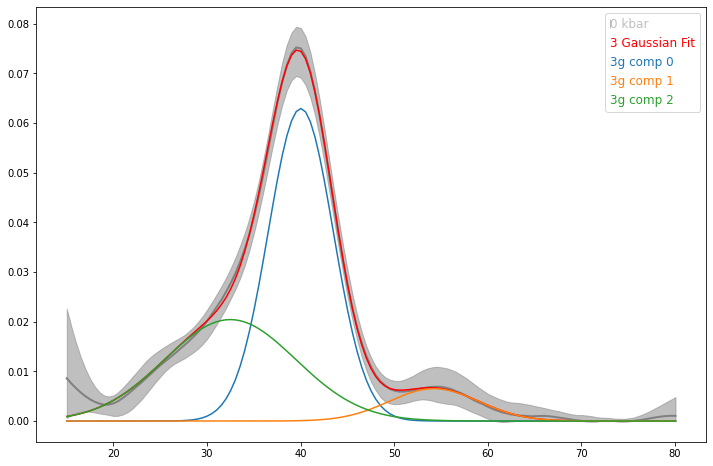

In [12]:
plt.rcParams['figure.figsize'] = 12,8
plt.plot(pdeer_0_148266['R'], pdeer_0_148266['Probability'], lw=2, color='grey')
plt.fill_between(pdeer_0_148266['R'], pdeer_0_148266['upper'], pdeer_0_148266['lower'], color = 'grey', label='0 kbar', alpha=0.5)
plt.plot(pdeer_0_148266['R'], gaus3_model(pdeer_0_148266['R'], *param_0kbar_3g), color='red', label = '3 Gaussian Fit')
for x in range(3):
    plt.plot(pdeer_0_148266['R'], gaus_model(pdeer_0_148266['R'], *param_0kbar_3g[3*x:3+3*x]), label='3g comp {}'.format(x))
plt.legend(fontsize=12, handlelength=0, handletextpad=0, labelcolor='linecolor')

In [13]:
param_0kbar_3g

array([6.29075203e-02, 4.00289360e+01, 3.47145133e+00, 6.52154556e-03,
       5.42479622e+01, 4.79526758e+00, 2.04263094e-02, 3.24992471e+01,
       7.00000000e+00])

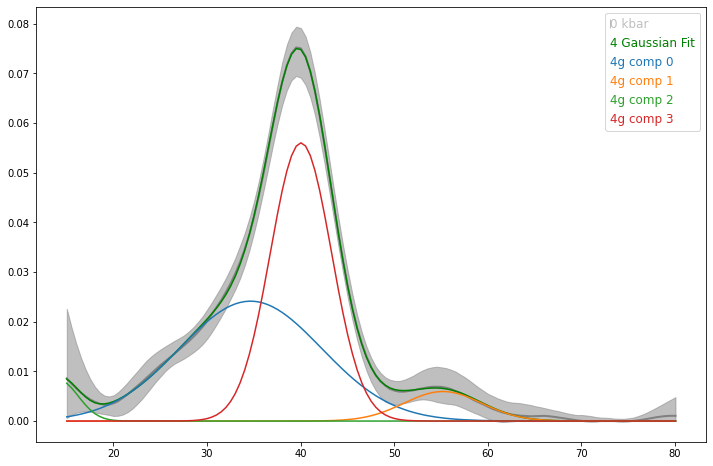

In [14]:
plt.plot(pdeer_0_148266['R'], pdeer_0_148266['Probability'], lw=2, color='grey')
plt.fill_between(pdeer_0_148266['R'], pdeer_0_148266['upper'], pdeer_0_148266['lower'], color = 'grey', label='0 kbar', alpha=0.5)
plt.plot(pdeer_0_148266['R'], gaus4_model(pdeer_0_148266['R'], *param_0kbar_4g), color='green', label = '4 Gaussian Fit')
for x in range(4):
    plt.plot(pdeer_0_148266['R'], gaus_model(pdeer_0_148266['R'], *param_0kbar_4g[3*x:3+3*x]), label='4g comp {}'.format(x))
plt.legend(fontsize=12, handlelength=0, handletextpad=0, labelcolor='linecolor')

Lorentzian fits are not good. Ignore these for future datasets. The below code will be left in this notebook for reference.

In [24]:
# lorentzian fits
p0_3l = [0.01, 30, 4, 0.01, 40, 3, 0.01, 55, 3, 0.01, 55, 3]
param_0kbar_3l, cov_0kbar_3l = curve_fit(loren4_model,pdeer_0_148266['R'], pdeer_0_148266['Probability'], 
                                         p0=p0_3l, bounds=(np.tile([0,0,0],4),np.tile([np.inf,np.inf,np.inf],4)))

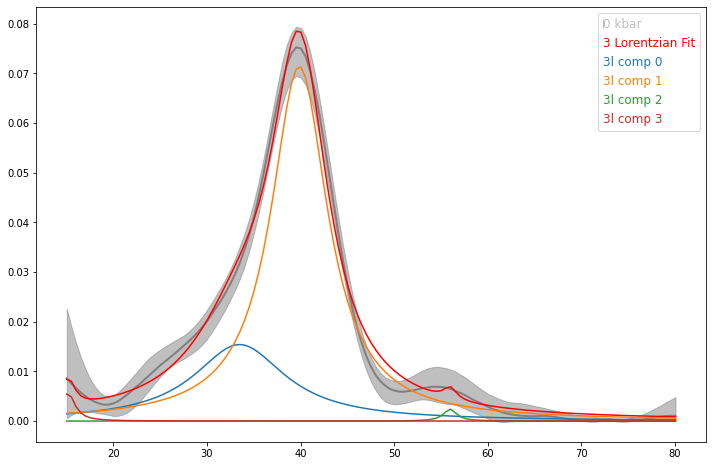

In [25]:
plt.rcParams['figure.figsize'] = 12,8
plt.plot(pdeer_0_148266['R'], pdeer_0_148266['Probability'], lw=2, color='grey')
plt.fill_between(pdeer_0_148266['R'], pdeer_0_148266['upper'], pdeer_0_148266['lower'], color = 'grey', label='0 kbar', alpha=0.5)
plt.plot(pdeer_0_148266['R'], loren4_model(pdeer_0_148266['R'], *param_0kbar_3l), color='red', label = '3 Lorentzian Fit')
for x in range(4):
    plt.plot(pdeer_0_148266['R'], loren_model(pdeer_0_148266['R'], *param_0kbar_3l[3*x:3+3*x]), label='3l comp {}'.format(x))
plt.legend(fontsize=12, handlelength=0, handletextpad=0, labelcolor='linecolor')

In [17]:
#now need to make a gaussian model for the rotamers
popc_5jqh = mda.Universe('step4_lipid_edit_noh_inactive.pdb') 
prot = popc_5jqh.select_atoms('protein or resname POPC') 

SL1 = xl.SpinLabel('I1M', site = 148, chain='PROA', protein=prot)
SL2 = xl.SpinLabel('I1M', site = 266, chain='PROA', protein=prot)

r = np.arange(15, 80, 0.1)

In [18]:
n=0
energy_f=[]
dist_f=[]
peak_f=[]

while n < 30:
    traj, de = xl.repack(prot, SL1, SL2,
                     repetitions=2500,
                     temp=310,
                     off_rotamer=False,
                     repack_radius=10) 
    SL1r = xl.SpinLabel.from_trajectory(traj, chain='PROA', site=266, burn_in=500, spin_atoms=SL1.spin_atoms)
    SL2r = xl.SpinLabel.from_trajectory(traj, chain='PROA', site=148, burn_in=500, spin_atoms=SL1.spin_atoms)
    energy_f.append(sum(np.cumsum(de)[100:])/len(np.cumsum(de)[100:]))
    
    P_repack_f = xl.distance_distribution(SL1r, SL2r, r)
    peak_f.append(r[np.where(P_repack_f == max(P_repack_f))[0][0]])
    dist_f.append(P_repack_f)
    print(n)
    n+=1

100%|██████████| 2500/2500 [00:09<00:00, 272.09it/s]
  zmat_idxs[chain], zmats[chain] = zmat_concat[:, :3].astype(int), zmat_concat[:, 3:].copy()



0


100%|██████████| 2500/2500 [00:08<00:00, 281.79it/s]


1


100%|██████████| 2500/2500 [00:08<00:00, 295.04it/s]


2


100%|██████████| 2500/2500 [00:08<00:00, 293.96it/s]


3


100%|██████████| 2500/2500 [00:07<00:00, 315.28it/s]


4


100%|██████████| 2500/2500 [00:08<00:00, 298.28it/s]


5


100%|██████████| 2500/2500 [00:08<00:00, 299.01it/s]


6


100%|██████████| 2500/2500 [00:08<00:00, 300.06it/s]


7


100%|██████████| 2500/2500 [00:08<00:00, 301.90it/s]


8


100%|██████████| 2500/2500 [00:08<00:00, 299.82it/s]


9


100%|██████████| 2500/2500 [00:08<00:00, 312.39it/s]


10


100%|██████████| 2500/2500 [00:08<00:00, 290.45it/s]


11


100%|██████████| 2500/2500 [00:08<00:00, 301.07it/s]


12


100%|██████████| 2500/2500 [00:08<00:00, 303.85it/s]


13


100%|██████████| 2500/2500 [00:08<00:00, 298.05it/s]


14


100%|██████████| 2500/2500 [00:08<00:00, 301.20it/s]


15


100%|██████████| 2500/2500 [00:08<00:00, 307.71it/s]


16


100%|██████████| 2500/2500 [00:08<00:00, 294.84it/s]


17


100%|██████████| 2500/2500 [00:08<00:00, 296.21it/s]


18


100%|██████████| 2500/2500 [00:08<00:00, 301.35it/s]


19


100%|██████████| 2500/2500 [00:08<00:00, 292.81it/s]


20


100%|██████████| 2500/2500 [00:08<00:00, 301.42it/s]


21


100%|██████████| 2500/2500 [00:08<00:00, 299.83it/s]


22


100%|██████████| 2500/2500 [00:08<00:00, 299.97it/s]


23


100%|██████████| 2500/2500 [00:08<00:00, 300.19it/s]


24


100%|██████████| 2500/2500 [00:08<00:00, 300.47it/s]


25


100%|██████████| 2500/2500 [00:07<00:00, 315.72it/s]


26


100%|██████████| 2500/2500 [00:07<00:00, 314.50it/s]


27


100%|██████████| 2500/2500 [00:08<00:00, 312.03it/s]


28


100%|██████████| 2500/2500 [00:08<00:00, 302.35it/s]


29


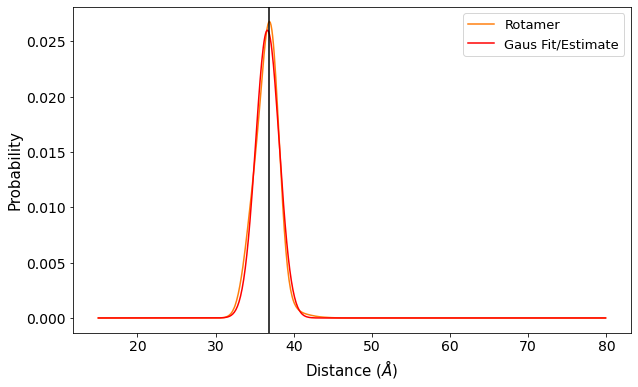

In [19]:
total = sum(dist_f)
cumul = total/sum(total)
p_rot=[0.03, 40, 5]
param_rot, cov_rot = curve_fit(gaus_model,r, cumul, p0=p_rot)

plt.rcParams['figure.figsize']  = 10,6
plt.plot(r, cumul, color='tab:orange', label='Rotamer')
plt.plot(r, gaus_model(r,*param_rot), label='Gaus Fit/Estimate', color='red')
plt.axvline(r[np.where(cumul == max(cumul))[0][0]], color='black')
#plt.text(30, 5, '%.1f' % r[np.where(cumul == max(cumul))[0][0]])
plt.xlabel('Distance ($\AA$)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=13)
plt.show()

In [20]:
print('Rotameric Distribution Peak: {}\nRotameric Distribution Width: {}'.format(param_rot[1], param_rot[2]))

Rotameric Distribution Peak: 36.63455921094241
Rotameric Distribution Width: 1.51336497562099


In [21]:
#now set up width subtraction method for C-alpha and center using formula
# width_data = 3.35
# width_rot  = 1.1

# w = width_data - width_rot

#Method to determine where the C-alpha distribution is centered -- generate gaussian

def calpha_center(exp, rot_xl, structure, site1, site2, width):
    '''
    exp (float): experimental gaussian distribution center
    rot_xl (float): rotameric distribution (as modeled by xl) center -- from a crystal
    structure (str): crystal structure to use for C-alpha distance
    site1/2 (float): sites to get C-alpha distance from
    width: width of C-alpha distribution
    '''
    u = mda.Universe(structure)
    s1=u.select_atoms("resid {} and name CA".format(site1))
    s2=u.select_atoms("resid {} and name CA".format(site2))
    resid1, resid2, struct_dist = distances.dist(s1, s2)
    
    ca_center = exp-abs(rot_xl-struct_dist)
    
    return ca_center #(gaus(ca_center, width), ca_center)

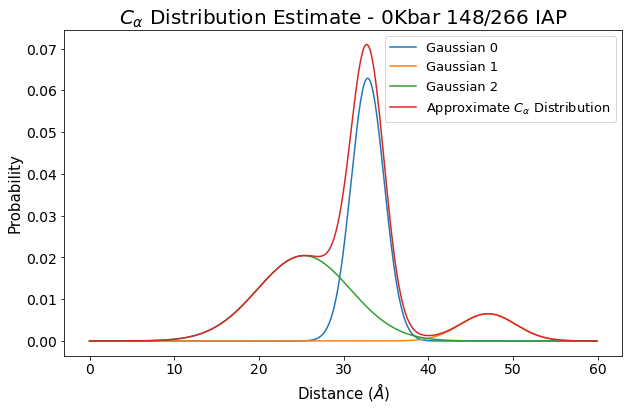

In [23]:
cum_ca = []
r_ = np.arange(0,60,0.1)

for n in range(0,int(len(param_0kbar_3g-3)/3)):
    width=param_0kbar_3g[2+n*3]-param_rot[2]
    center = calpha_center(param_0kbar_3g[1+n*3], param_rot[1], '5jqh_d6m_model_jg_p.pdb', 148, 266, width)
    gaus = gaus_model(r_,param_0kbar_3g[0+n*3], center, width)
    plt.plot(r_,gaus,label='Gaussian {}'.format(n))
    cum_ca.append(gaus)

cum_ca = np.sum(cum_ca, axis=0)
plt.plot(r_, cum_ca, label=r'Approximate $C_\alpha$ Distribution')
plt.xlabel('Distance ($\AA$)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=13)
plt.title(r'$C_\alpha$ Distribution Estimate - 0Kbar 148/266 IAP', fontsize=20)
plt.show()

In [24]:
param_rot[1]

36.63455921094241

In [25]:
width

5.486635024379009